In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image

import torchvision.datasets as dset
import torchvision.transforms as T
# import chest_xray_code.data.xrays as preprocess_dataset
# import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F
from models.NewConvModel import NewConvNet 
from loaders.MuseumLoader256 import MuseumLoader256



import numpy as np

In [2]:
filenames = glob.glob(osp.join('/home/shared/proj/museum_data/dataset_updated/training_set', '*.jpg'))
#print(filenames)

for filename in filenames:
    image_fn = filename
    try:
        #print(image_fn)
        image = Image.open(image_fn)
        image = image.resize((200,200),Image.ANTIALIAS)
    except IOError:
        os.remove(image_fn)
        print(image_fn)    

    removed_name = False
    if image is None:
        os.remove(image_fn)
        print(image_fn)
        removed_name = True
    image = np.array(image)

    if image.shape != (200,200,3) and not removed_name:
        os.remove(image_fn)
        print(image_fn)

            
    

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


In [14]:
trainset = MuseumLoader256(
    root='/home/shared/proj/museum_data/dataset_updated/training_set',
    sample_size = 500,
    preload=False, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=20, shuffle=True, num_workers=32)

# load the testset
testset = MuseumLoader256(
   root='/home/shared/proj/museum_data/dataset_updated/validation_set',
    sample_size = 100,
   preload=False, transform=transforms.ToTensor(),
)
#testset = trainset
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=20, shuffle=True, num_workers=32)

print(len(trainset))
print(len(testset))

500
100


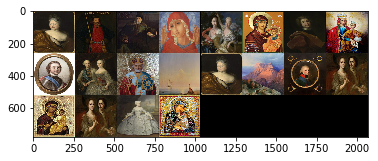

In [15]:
def imshow_noax(img, normalize=True):
    #Tiny helper to show images as uint8 and remove axis labels 
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')
    
    # functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # get some random training images
# dataiter = iter(trainset_loader)

# images = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))


In [5]:
NUM_TRAIN = 100

transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
loader_train = trainset
images = {}

In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 25


# Architecture and Training

In [7]:
class TestConvNet(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_3_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_3_compress = nn.BatchNorm2d(size)
        self.relu_3_compress = nn.ReLU()
        
        self.conv_4_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_compress = nn.BatchNorm2d(size)
        self.relu_4_compress = nn.ReLU()
        
        self.conv_5_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_compress = nn.BatchNorm2d(size)
        self.relu_5_compress = nn.ReLU()
        
        self.conv_6_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_6_compress = nn.BatchNorm2d(size)
        self.relu_6_compress = nn.ReLU()

        self.conv_downsize_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_downsize_compress = nn.BatchNorm2d(size)
        self.relu_downsize_compress = nn.ReLU()
        
        self.conv_7_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_compress = nn.BatchNorm2d(size)
        self.relu_7_compress = nn.ReLU()
        
        self.conv_8_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_8_compress = nn.BatchNorm2d(size)
        self.relu_8_compress = nn.ReLU()
        
        self.conv_9_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_compress = nn.BatchNorm2d(size)
        self.relu_9_compress = nn.ReLU()
        
        self.conv_10_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_compress = nn.BatchNorm2d(size)
        self.relu_10_compress = nn.ReLU()
        
        self.conv_11_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_11_compress = nn.BatchNorm2d(size)
        self.relu_11_compress = nn.ReLU()
        
        self.conv_12_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_12_compress = nn.BatchNorm2d(size)
        self.relu_12_compress = nn.ReLU()
        
        self.conv_13_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_13_compress = nn.BatchNorm2d(size)
        self.relu_13_compress = nn.ReLU()
        
        
        self.conv_compress_final = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.upscaling2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.upscaling3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_decompress = nn.BatchNorm2d(size)
        self.relu_10_decompress = nn.ReLU()
        
        self.conv_11_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_11_decompress = nn.BatchNorm2d(size)
        self.relu_11_decompress = nn.ReLU()
        
        self.conv_12_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_12_decompress = nn.BatchNorm2d(size)
        self.relu_12_decompress = nn.ReLU()
        
        self.upscaling4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_13_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_13_decompress = nn.BatchNorm2d(size)
        self.relu_13_decompress = nn.ReLU()
        
        self.conv_14_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_14_decompress = nn.BatchNorm2d(size)
        self.relu_14_decompress = nn.ReLU()
        
        self.conv_15_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_15_decompress = nn.BatchNorm2d(size)
        self.relu_15_decompress = nn.ReLU()
        
        self.conv_16_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_16_decompress = nn.BatchNorm2d(size)
        self.relu_16_decompress = nn.ReLU()
        
        self.conv_17_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( 
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_3_compress,
            self.batchnorm_3_compress,
            self.relu_3_compress,
            
            self.conv_4_compress,
            self.batchnorm_4_compress,
            self.relu_4_compress,
            
            self.conv_5_compress,
            self.batchnorm_5_compress,
            self.relu_5_compress,
            
            self.conv_6_compress,
            self.batchnorm_6_compress,
            self.relu_6_compress,
            
            self.conv_downsize_compress,
            self.batchnorm_downsize_compress,
            self.relu_downsize_compress,
            
            self.conv_7_compress,
            self.batchnorm_7_compress,
            self.relu_7_compress,
            
            self.conv_8_compress,
            self.batchnorm_8_compress,
            self.relu_8_compress,
            
            self.conv_9_compress,
            self.batchnorm_9_compress,
            self.relu_9_compress,
            
            self.conv_10_compress,
            self.batchnorm_10_compress,
            self.relu_10_compress,
            
            self.conv_11_compress,
            self.batchnorm_11_compress,
            self.relu_11_compress,
            
            self.conv_12_compress,
            self.batchnorm_12_compress,
            self.relu_12_compress,
            
            self.conv_13_compress,
            self.batchnorm_13_compress,
            self.relu_13_compress,
            
            self.conv_compress_final,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.upscaling2,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.upscaling3,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
            
            self.conv_10_decompress,
            self.batchnorm_10_decompress,
            self.relu_10_decompress,
            
            self.conv_11_decompress,
            self.batchnorm_11_decompress,
            self.relu_11_decompress,
            
            self.conv_12_decompress,
            self.batchnorm_12_decompress,
            self.relu_12_decompress,
            
            self.upscaling4,
        
            self.conv_13_decompress,
            self.batchnorm_13_decompress,
            self.relu_13_decompress,
            
            self.conv_14_decompress,
            self.batchnorm_14_decompress,
            self.relu_14_decompress,
            
            self.conv_15_decompress,
            self.batchnorm_15_decompress,
            self.relu_15_decompress,
            
            self.conv_16_decompress,
            self.batchnorm_16_decompress,
            self.relu_16_decompress,
            
            self.conv_17_decompress

            
        ).to(device)
        scores = model(x)
        return scores
    

In [8]:
def train(model, epoch, log_interval=100):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model = torch.nn.DataParallel(model)
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data) in enumerate(trainset_loader):
            data = data.to(device=device, dtype=dtype)
            optimizer.zero_grad()
            #print(data.shape)
            reconstruction = model(data)
            loss_function = nn.MSELoss(size_average=True)
            loss = loss_function(reconstruction, data)
            loss.backward()
            optimizer.step()
        if ep % print_every == 0:
            print('Iteration %d, loss = %.4f' % (ep, loss.item()))
            print()
            torch.save(model, 'museum256.pt')
            torch.save(model.state_dict(), 'museum256_dict.pt')

def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testset_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):

        individual_img = img[i]
        axarr[i,1].axis('off')
        axarr[i,1].imshow(prep(individual_img))
        images[1].append(prep(individual_img))
    

In [18]:
channels = 3
size = 32
model = TestConvNet(channels,size)
#hook = model.conv_compress_final.register_forward_hook(save_compressed)
#hook.remove()

optimizer = optim.Adam(model.parameters(), lr=5e-3) 
train(model,100)
torch.save(model, 'museum256.pt')

Iteration 0, loss = 0.0293

Iteration 5, loss = 0.0252

Iteration 10, loss = 0.0110

Iteration 15, loss = 0.0166

Iteration 20, loss = 0.0226

Iteration 25, loss = 0.0144

Iteration 30, loss = 0.0175

Iteration 35, loss = 0.0130

Iteration 40, loss = 0.0118

Iteration 45, loss = 0.0147

Iteration 50, loss = 0.0157

Iteration 55, loss = 0.0109

Iteration 60, loss = 0.0144

Iteration 65, loss = 0.0144

Iteration 70, loss = 0.0168

Iteration 75, loss = 0.0139

Iteration 80, loss = 0.0122

Iteration 85, loss = 0.0139

Iteration 90, loss = 0.0124

Iteration 95, loss = 0.0127



/home/shared/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type TestConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [19]:
class save_output(nn.Module):
    def forward(self, x):
       
        with torch.no_grad():
            img = x.cpu().detach()
            imshow_noax(torchvision.utils.make_grid(img))
        return x
"""
plt.close("all")
f,axarr = plt.subplots(20, 2,figsize=(400,400))

f.tight_layout()
f.subplots_adjust(left=0, bottom=0, right=.1, top=.1, wspace=0, hspace=.1)

images = [[],[]]

def prep(img):
    img = img.numpy()
    if True:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    return np.transpose(img, (1, 2, 0))
    
def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):

        individual_img = img[i]
        axarr[i,1].axis('off')
        axarr[i,1].imshow(prep(individual_img))
        images[1].append(prep(individual_img))
    
    
        
        

def save_original(data):
    img = data.cpu().detach()
    
    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        axarr[i,0].axis('off')
        axarr[i,0].imshow(individual_img)
        images[0].append(individual_img)



model = torch.load('MuseumModel.pt')

model.conv_compress_final.register_forward_hook(save_compressed)
i = 0
reconstruction = None
for data in trainset_loader:
    with torch.no_grad():
        if i > 0: break
        data = data.to(device)
        display_original(data)
        reconstruction = model(data)
        i+=1
"""


'\nplt.close("all")\nf,axarr = plt.subplots(20, 2,figsize=(400,400))\n\nf.tight_layout()\nf.subplots_adjust(left=0, bottom=0, right=.1, top=.1, wspace=0, hspace=.1)\n\nimages = [[],[]]\n\ndef prep(img):\n    img = img.numpy()\n    if True:\n        img_max, img_min = np.max(img), np.min(img)\n        img = 255.0 * (img - img_min) / (img_max - img_min)\n    return np.transpose(img, (1, 2, 0))\n    \ndef save_compressed(self,input,output):\n    #for i in range(1):\n    img = output.cpu().detach()\n    for i in range(img.shape[0]):\n\n        individual_img = img[i]\n        axarr[i,1].axis(\'off\')\n        axarr[i,1].imshow(prep(individual_img))\n        images[1].append(prep(individual_img))\n    \n    \n        \n        \n\ndef save_original(data):\n    img = data.cpu().detach()\n    \n    for i in range(img.shape[0]):\n        individual_img = img[i]\n        individual_img = individual_img.numpy()\n        individual_img = np.transpose(individual_img, (1, 2, 0))\n        axarr[i,0]

test loss tensor(1.00000e-03 *
       6.5845)


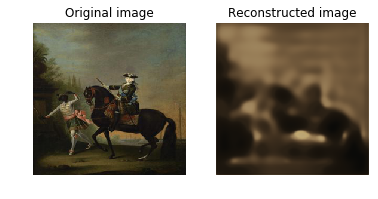

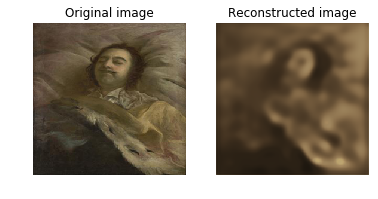

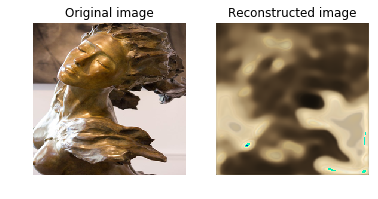

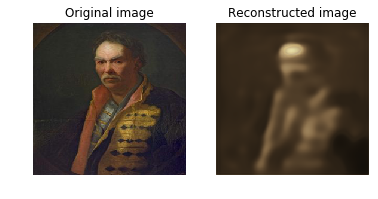

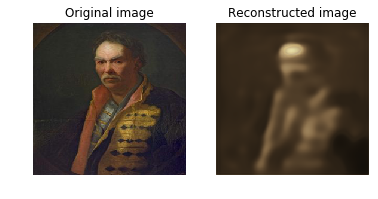

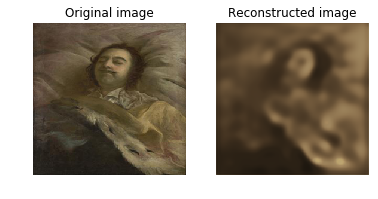

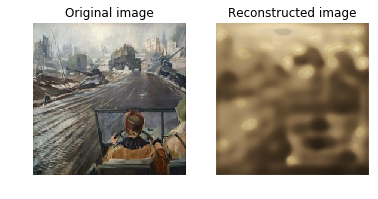

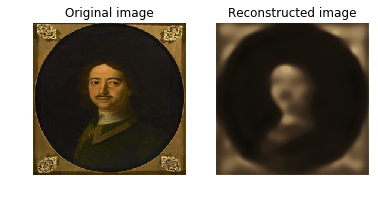

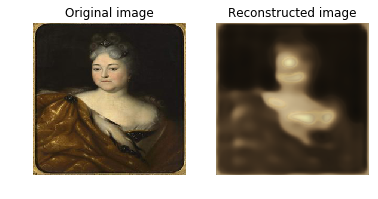

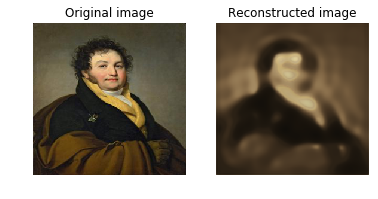

In [20]:
# z = torch.zeros(10,3,256,256)
# i = 0
# for k in range(0,10):
#    y = testset.__getitem__(k)
#    #print(y.shape)
#    z[i] = y
#    i +=1
# originals = z
# originals = originals.to(device=device, dtype=dtype)
# reconstruction = model(originals)
# loss_function = nn.MSELoss(size_average=True)
# test_loss = loss_function(reconstruction, originals)
# print('test loss', test_loss)

# for i in range(10):
#    plt.figure()
#    org = originals[i].cpu().detach().numpy().transpose(1,2,0)
#    plt.subplot(1, 2, 1)
#    imshow_noax(org, normalize=False)
#    plt.title('Original image')
#    plt.subplot(1, 2, 2)
#    rec = reconstruction[i].cpu().detach().numpy().transpose(1,2,0)
#    imshow_noax(rec, normalize=False)
#    plt.title('Reconstructed image')
#    plt.show()

